In [1]:
import os, sys
sys.path.append("..")
sys.path.append("../ALAE")

import torch
import numpy as np
import ot

from src.distributions import LoaderSampler, TensorSampler
from src.ulight_ot import ULightOT
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import accuracy_score

import wandb
import matplotlib
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from IPython.display import clear_output

from alae_ffhq_inference import load_model, encode, decode
from src.plotters import fig2img
from src.fid_score import calculate_frechet_distance
from src.ulight_ot import ULightOT

%matplotlib inline

%load_ext autoreload
%autoreload 2

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Load the Datasets

In [2]:
DIM = 512
assert DIM > 1

INPUT_DATA = "YOUNG" # MAN, WOMAN, ADULT, YOUNG
TARGET_DATA = "ADULT" # MAN, WOMAN, ADULT, YOUNG

OUTPUT_SEED = 42
BATCH_SIZE = 128
EPSILON = 0.05
DIVERGENCE = 'KL'#"KL" #balanced
K_POTENTIALS = L_POTENTIALS = 10
Tau = 100 # unbalancedness parameter
D_LR = 1
D_GRADIENT_MAX_NORM = 1e5 #float("inf")
SAMPLING_BATCH_SIZE = 128
INIT_BY_SAMPLES = True
IS_DIAGONAL = True

MAX_STEPS = 5000
CONTINUE = -1

CONTINUE = -1

DEVICE = 'cpu'

We download the data and neural network extracted features for the FFHQ dataset from https://github.com/ngushchin/LightSB using the code below

In [3]:
# import gdown
# import os

# urls = {
#     "../data/age.npy": "https://drive.google.com/uc?id=1Vi6NzxCsS23GBNq48E-97Z9UuIuNaxPJ",
#     "../data/gender.npy": "https://drive.google.com/uc?id=1SEdsmQGL3mOok1CPTBEfc_O1750fGRtf",
#     "../data/latents.npy": "https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8",
#     "../data/test_images.npy": "https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i",
# }

# for name, url in urls.items():
#     gdown.download(url, os.path.join(f"{name}"), quiet=False)

In [3]:
# To download data use
train_size = 60000
test_size = 10000

latents = np.load("../data/latents.npy")
gender = np.load("../data/gender.npy")
age = np.load("../data/age.npy")
test_inp_images = np.load("../data/test_images.npy")

train_latents, test_latents = latents[:train_size], latents[train_size:]
train_gender, test_gender = gender[:train_size], gender[train_size:]
train_age, test_age = age[:train_size], age[train_size:]

## Define Classifiers

In [4]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        self.layer3 = nn.Linear(128, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = torch.sigmoid(self.layer3(out))
        return out

## ALAE

In [5]:
model = load_model("../ALAE/configs/ffhq.yaml", training_artifacts_dir="../ALAE/training_artifacts/ffhq/")

## Visualization

In [6]:
def decode_and_plot(T, latent_to_map, inp_images):
    mapped_all = []
    with torch.no_grad():
        for k in range(number_of_samples):
            mapped = T(latent_to_map)
            mapped_all.append(mapped)

    mapped = torch.stack(mapped_all, dim=1)

    decoded_all = []
    with torch.no_grad():
        for k in range(number_of_samples):
            decoded_img = decode(model, mapped[:, k].detach().cpu())
            decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
            decoded_all.append(decoded_img)

    decoded_all = np.stack(decoded_all, axis=1)
    
    fig, axes = plt.subplots(number_of_samples+1, latent_to_map.shape[0], figsize=(latent_to_map.shape[0], number_of_samples+1), dpi=200)

    for i, ind in enumerate(range(latent_to_map.shape[0])):
    #     ax = axes[i]
        axes[0, i].imshow(inp_images[ind])
        for k in range(number_of_samples):
            axes[k+1, i].imshow(decoded_all[ind, k])

            axes[k+1, i].get_xaxis().set_visible(False)
            axes[k+1, i].set_yticks([])

        axes[0, i].get_xaxis().set_visible(False)
        axes[0, i].set_yticks([])

    fig.tight_layout(pad=0.05)
    
    return fig, axes

## Model initialization

In [7]:
EXP_NAME = f'ULightOT_{INPUT_DATA}_TO_{TARGET_DATA}'
OUTPUT_PATH = './checkpoints/{}'.format(EXP_NAME)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
if INPUT_DATA == "MAN":
    x_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif INPUT_DATA == "WOMAN":
    x_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif INPUT_DATA == "ADULT":
    x_inds_train = np.arange(train_size)[
        (train_age > 44).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        (test_age > 44).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif INPUT_DATA == "YOUNG":
    x_inds_train = np.arange(train_size)[
        ((train_age > 16) & (train_age <= 44)).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        ((test_age > 16) & (test_age <= 44)).reshape(-1)*(test_age != -1).reshape(-1)
    ]

if TARGET_DATA == "MAN":
    y_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif TARGET_DATA == "WOMAN":
    y_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif TARGET_DATA == "ADULT":
    y_inds_train = np.arange(train_size)[
        (train_age > 44).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        (test_age > 44).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif TARGET_DATA == "ADULT-MAN":
    male_train = np.arange(train_size)[(train_gender == "male")]
    male_test = np.arange(test_size)[(test_gender == "male")]
    
    y_inds_train = male_train[(train_age[male_train].reshape(-1) > 44)]#*(train_age != -1)
    y_inds_test = male_test[(test_age[male_test].reshape(-1) > 44)]#*(test_age != -1).reshape(-1)
elif TARGET_DATA == "YOUNG":
    y_inds_train = np.arange(train_size)[
        ((train_age > 16) & (train_age <= 44)).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        ((test_age > 16) & (test_age <= 44)).reshape(-1)*(test_age != -1).reshape(-1)
    ]
    
if INPUT_DATA in ['ADULT', 'YOUNG']:
    mlp_classifier = BinaryClassifier()
    mlp_classifier.load_state_dict(torch.load('./checkpoints/male_female_classifier.pth', map_location=DEVICE))
    
    target_mlp_classifier = BinaryClassifier()
    target_mlp_classifier.load_state_dict(torch.load('./checkpoints/young_old_classifier.pth', map_location=DEVICE))
elif INPUT_DATA in ['MAN', 'WOMAN']:
    mlp_classifier = BinaryClassifier()
    mlp_classifier.load_state_dict(torch.load('./checkpoints/young_old_classifier.pth', map_location=DEVICE))
    
    target_mlp_classifier = BinaryClassifier()
    target_mlp_classifier.load_state_dict(torch.load('./checkpoints/male_female_classifier.pth', map_location=DEVICE))

x_data_train = train_latents[x_inds_train]
x_data_test = test_latents[x_inds_test]
x_data_test_gender = test_gender[x_inds_test]
x_data_test_age = test_age[x_inds_test]

inds_to_map = np.random.choice(np.arange((x_inds_test < 300).sum()), size=10, replace=False)
number_of_samples = 1
mapped_all = []
latent_to_map = torch.tensor(test_latents[x_inds_test[inds_to_map]])
inp_images = test_inp_images[x_inds_test[inds_to_map]]
    
y_data_train = train_latents[y_inds_train]
y_data_test = test_latents[y_inds_test]

X_train = torch.tensor(x_data_train)
Y_train = torch.tensor(y_data_train)

X_test = torch.tensor(x_data_test)
Y_test = torch.tensor(y_data_test)

X_sampler = TensorSampler(X_train, device="cpu")
Y_sampler = TensorSampler(Y_train, device="cpu")

In [8]:
#compute real data stats: (for FD metrics)

real_data = Y_sampler.sample(10000)
real_data = real_data.cpu().data.numpy().reshape(real_data.size(0), -1)
mu_data, sigma_data = np.mean(real_data, axis=0), np.cov(real_data, rowvar=False)

In [9]:
torch.manual_seed(OUTPUT_SEED); np.random.seed(OUTPUT_SEED)


D = ULightOT(dim=DIM, k_potentials=K_POTENTIALS, l_potentials=L_POTENTIALS,epsilon=EPSILON,
            sampling_batch_size=SAMPLING_BATCH_SIZE, is_diagonal=IS_DIAGONAL)

log_m = torch.zeros(1, requires_grad=True)

if INIT_BY_SAMPLES:
    D.init_r_by_samples(Y_sampler.sample(K_POTENTIALS))

D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)
m_opt = torch.optim.Adam([log_m], lr=1e-3)
D_sch = MultiStepLR(D_opt, milestones=[500, 1000])

if CONTINUE > -1:
    D_opt.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'D_opt_{SEED}_{CONTINUE}.pt')))

## Training

In [10]:
for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    # training cycle
    D_opt.zero_grad(); m_opt.zero_grad();
    if step < 1000:
        tau = 1000
    else:
        tau = Tau

    X, Y = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)

    log_V = D.get_potential(Y)
    psi = EPSILON * log_V + torch.norm(Y, p=2, dim=-1)**2/2 
    if DIVERGENCE == 'KL':
        f_psi = tau * (torch.exp(-psi/tau) - 1)
    elif DIVERGENCE == 'Xi2':
        psi = -(F.relu(-psi + 2*tau) - (1+(-psi>-2*tau))*tau)
        f_psi = 0.25 * psi**2/tau - psi
    elif DIVERGENCE == 'balanced':
        f_psi = -psi

    log_C = D.get_C(X)
    log_U = D.get_marginal(X)
    phi = EPSILON * (log_U + log_m - log_C) + torch.norm(X, p=2, dim=-1)**2/2

    if DIVERGENCE == 'KL':
        f_phi = tau * (torch.exp(-phi/tau) - 1)
    elif DIVERGENCE == 'Xi2':
        phi = -(F.relu(-phi + 2*tau) - (1+(-phi>-2*tau))*tau)
        f_phi = 0.25 * phi**2/tau - phi
    elif DIVERGENCE == 'balanced':
        f_phi = -phi

    D_loss = EPSILON * torch.exp(log_m) + f_phi.mean() + f_psi.mean()
    D_loss.backward()
    D_gradient_norm = torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
    D_opt.step(); m_opt.step();
    D_sch.step()

100%|██████████| 5000/5000 [01:29<00:00, 56.10it/s]


In [11]:
D_test = D(X_test)
mlp_classifier.eval()
pred_labels = mlp_classifier(D_test)
pred_labels = torch.round(pred_labels.squeeze())

pred_labels_np = pred_labels.data

target_mlp_classifier.eval()
target_pred_labels = target_mlp_classifier(D_test)
target_pred_labels = torch.round(target_pred_labels.squeeze())

target_pred_labels_np = target_pred_labels.data

if INPUT_DATA == 'ADULT' or INPUT_DATA == 'YOUNG':
    actual_labels_np = np.where(x_data_test_gender == 'male', 1, 0)
    if INPUT_DATA == 'YOUNG':
        target_actual_labels_np = np.ones(x_data_test_gender.shape[0])
    elif INPUT_DATA == 'ADULT':
        target_actual_labels_np = np.zeros(x_data_test_gender.shape[0])
elif INPUT_DATA in ['MAN', 'WOMAN']:
    actual_labels_np = (x_data_test_age.reshape(-1) > 44)*1
    if INPUT_DATA == 'WOMAN':
        target_actual_labels_np = np.ones(x_data_test_gender.shape[0])
    elif INPUT_DATA == 'MAN':
        target_actual_labels_np = np.zeros(x_data_test_gender.shape[0])
accuracy = accuracy_score(pred_labels_np, actual_labels_np)
target_accuracy = accuracy_score(target_pred_labels_np, target_actual_labels_np)
print('Accuracy: ', accuracy)
print('Target accuracy:', target_accuracy)

D_test = D_test.cpu().data.numpy().reshape(D_test.size(0), -1)
mu, sigma = np.mean(D_test, axis=0), np.cov(D_test, rowvar=False)
FD_T = calculate_frechet_distance(mu, sigma, mu_data, sigma_data)
print('FD: ', FD_T)

Accuracy:  0.8801955990220048
Target accuracy: 0.7764364303178484
FD:  18.25378601342021


## Visualization of results

In [12]:
def decode_and_plot(T, latent_to_map, inp_images):
    mapped_all = []
    with torch.no_grad():
        for k in range(number_of_samples):
            mapped = T(latent_to_map)
            mapped_all.append(mapped)

    mapped = torch.stack(mapped_all, dim=1)

    decoded_all = []
    with torch.no_grad():
        for k in range(number_of_samples):
            decoded_img = decode(model, mapped[:, k].detach().cpu())
            decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
            decoded_all.append(decoded_img)

    decoded_all = np.stack(decoded_all, axis=1)
    
    fig, axes = plt.subplots(number_of_samples+1, latent_to_map.shape[0], figsize=(latent_to_map.shape[0], number_of_samples+1), dpi=200)

    for i, ind in enumerate(range(latent_to_map.shape[0])):
        axes[0, i].imshow(inp_images[ind])
        for k in range(number_of_samples):
            axes[k+1, i].imshow(decoded_all[ind, k])

            axes[k+1, i].get_xaxis().set_visible(False)
            axes[k+1, i].set_yticks([])

        axes[0, i].get_xaxis().set_visible(False)
        axes[0, i].set_yticks([])

    fig.tight_layout(pad=0.05)
    
    return fig, axes

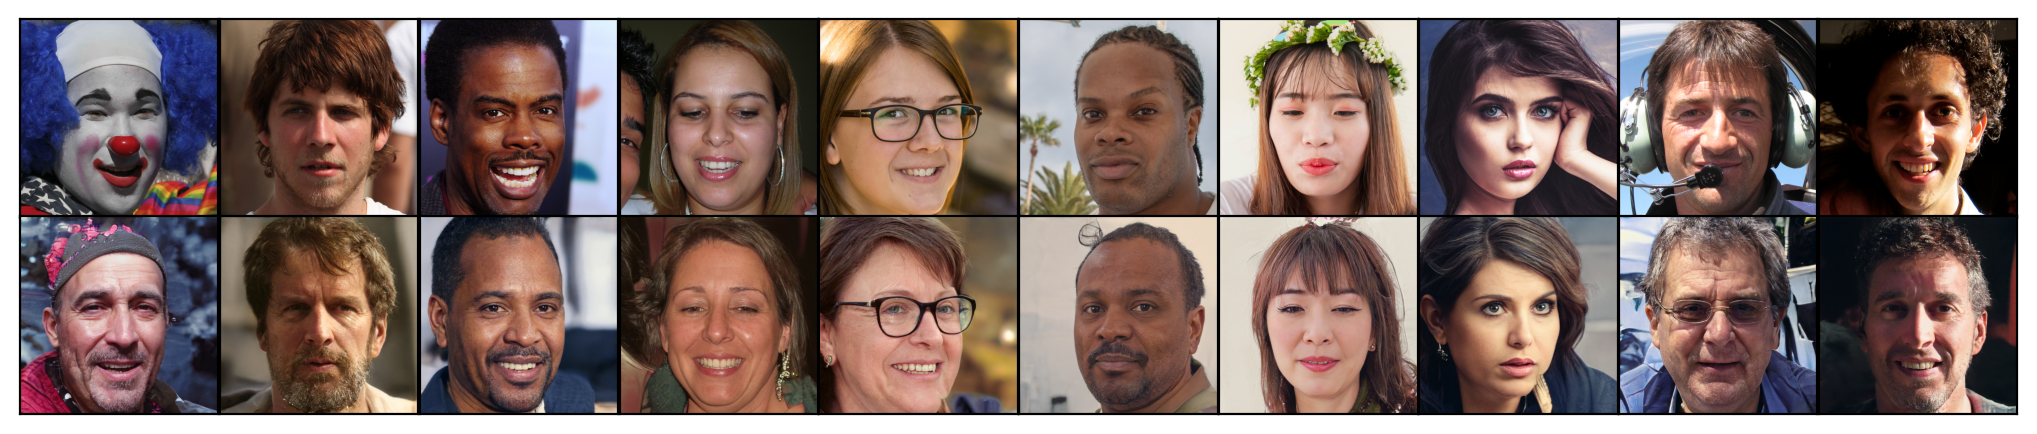

In [13]:
decode_and_plot(D, latent_to_map, inp_images)
%matplotlib inline
plt.show()